In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *





#wmt modes

process_gen_modes=[ "wmt_samples0", "wmt_samples1", "wmt_samples2_1","wmt_samples2_2", "wmt_samples3", "wmt_samples4",]


dfs_by_model,processGens,(root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)= get_dfs_by_model(process_gen_modes)
examples_df = pd.concat(list(dfs_by_model.values()))

# processGens=ProcessGens()
# processGens.init_with_mode(process_gen_modes)
# root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
# examples_df, completions_df=get_dfs(processGens)


# dfs_by_model={}
# for model_name in examples_df['model'].unique():
#     filtered_df = examples_df[examples_df["model"]==model_name]
#     dfs_by_model[model_name]=filtered_df
    
# all_dfs_by_model=dfs_by_model




/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


In [2]:
# print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
#     f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# # instanceGeneration=get_first(processGens.first_run_instances)
# print(examples_df.head(2))
# print("num examples" ,len(examples_df))
# print("num_completions", len(completions_df))
# print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
# #current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

meta_llama_Llama_3.1_8B_Instruct
allenai_OLMo_2_0425_1B_Instruct
meta_llama_Llama_3.2_1B_Instruct
allenai_OLMo_2_1124_7B_Instruct
allenai_OLMo_2_1124_13B_Instruct
Qwen/Qwen3-0.6B
Qwen/Qwen3-1.7B
Qwen/Qwen3-4B
Qwen/Qwen3-8B


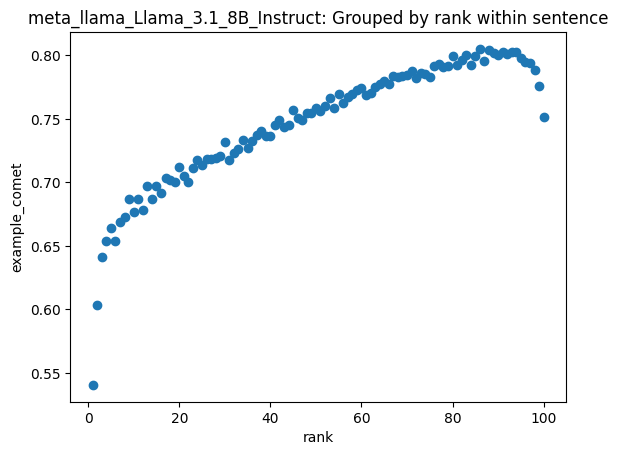

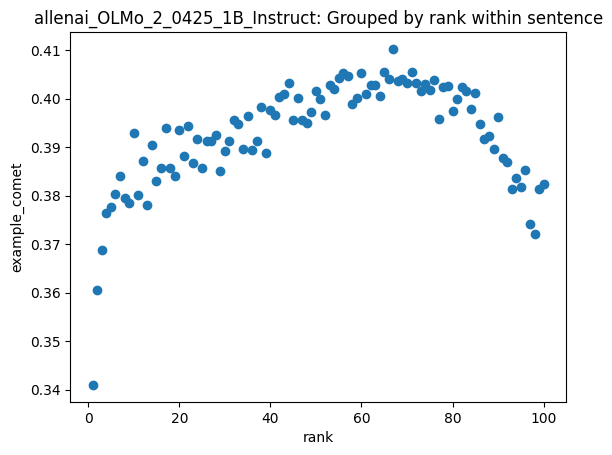

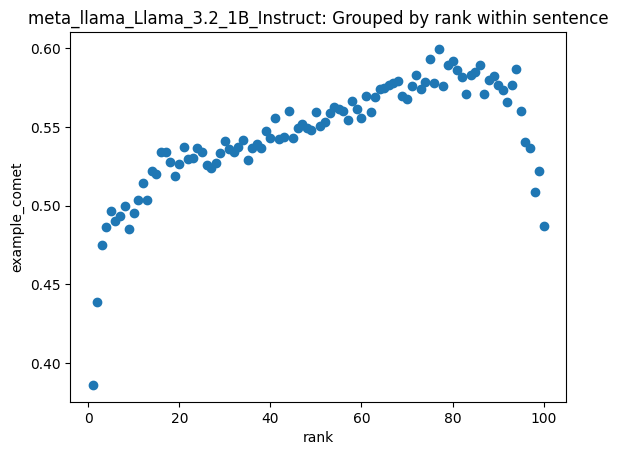

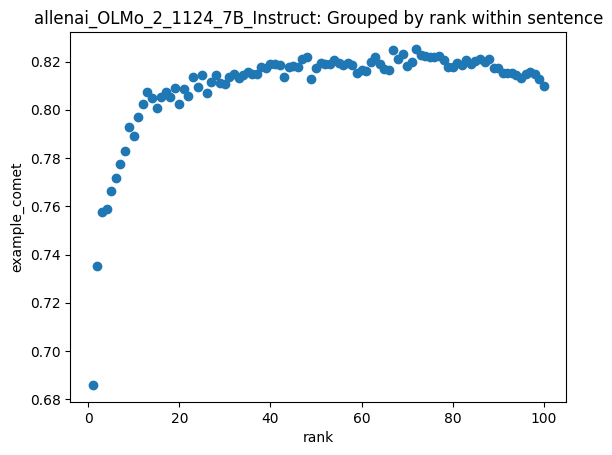

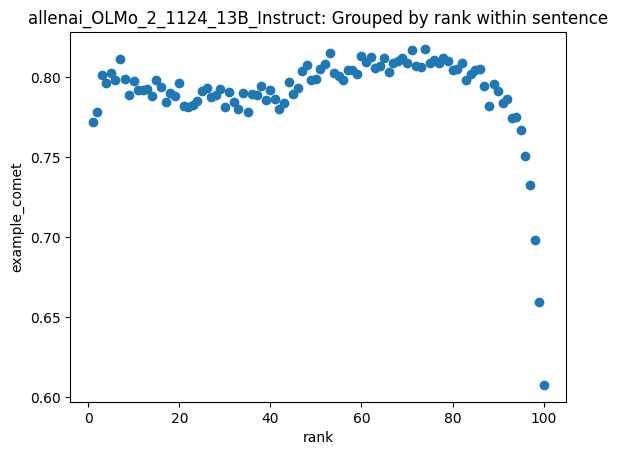

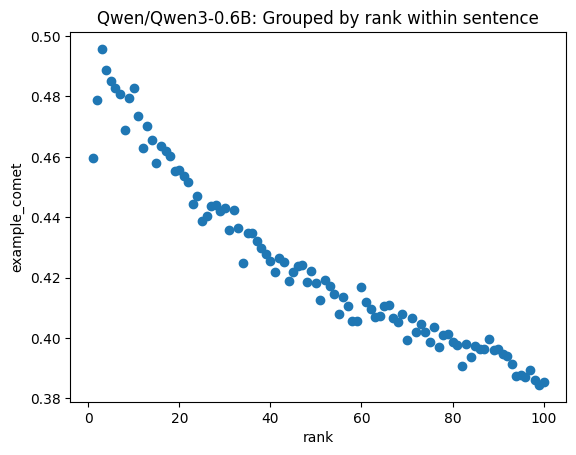

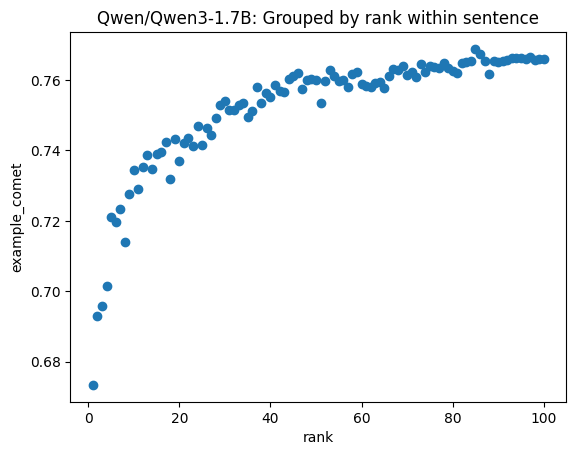

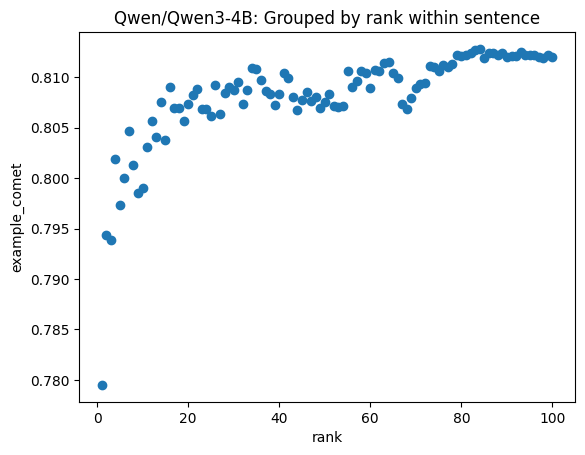

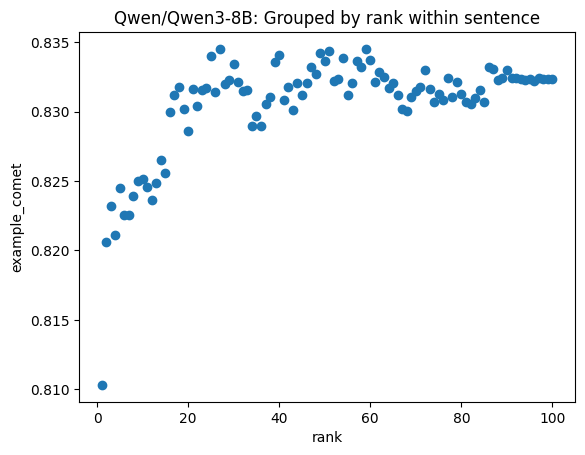

In [3]:

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None


for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    
    if axs is None:
        ax=None
    else:
        title=model_name
        if(num_models>1):
            axs_x=idx % plots_wide
            axs_y= math.floor(idx / plots_wide)
            ax=axs[axs_x, axs_y]
        else:
            ax=axs
    

    print(model_name)
    def calculate_title():
        return f"{model_name}: {suptitle}" if ax is None else model_name
    # plot by rank within sentence
    suptitle="Grouped by rank within sentence"
    # plot_smooth_spline(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax) 
    plot_grouped(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)  

if fig is not None:
    fig.suptitle(title)
    fig.tight_layout()
    

In [4]:
from process_gen_utils import get_model_details

model_name is meta_llama_Llama_3.2_1B_Instruct
model_name is meta_llama_Llama_3.1_8B_Instruct
model_name is allenai_OLMo_2_0425_1B_Instruct
model_name is allenai_OLMo_2_1124_7B_Instruct
model_name is allenai_OLMo_2_1124_13B_Instruct
model_name is Qwen/Qwen3-0.6B
model_name is Qwen/Qwen3-1.7B
model_name is Qwen/Qwen3-4B
model_name is Qwen/Qwen3-8B


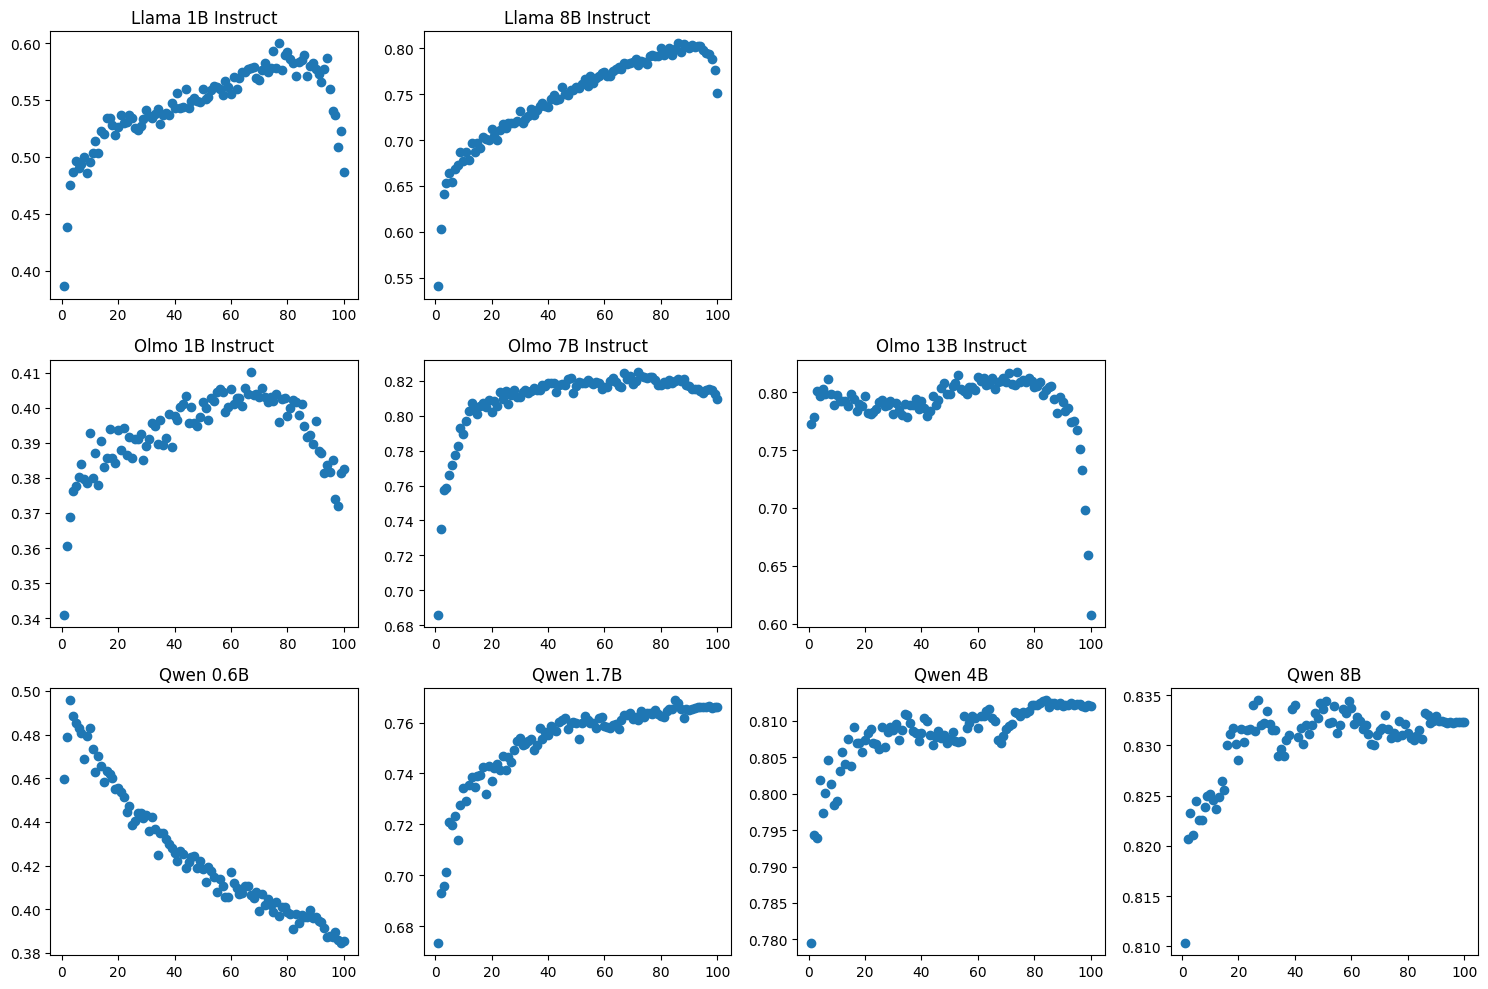

In [5]:

def plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=True, show_labels=False):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    x = grouped[(xlabel, 'mean')]
    y = grouped[(ylabel, 'mean')]
    yerr = grouped[(ylabel, 'std')]

    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        if c>0:
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)
    if error_bar:
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)

    # plt.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if(title):
        ax.set_title(title)

    if(trend_line=="None"):
        pass
    elif(trend_line=="linear"):
        try:
            ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        except:
            pass
    else: 
        raise Exception("Plot_keys errors: did not recognize trend_line type")
    return ax




def qualitative_plots(models_array, figsize=(15,10)):
    
    nrows=len(models_array)
    ncols=max(len(s) for s in models_array)
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, suite_models in enumerate(models_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(suite_models):
                model_name=suite_models[col]
                print(f"model_name is {model_name}")

                filtered_df=dfs_by_model[model_name]
                def calculate_title():
                    readable_model=get_model_details(model_name)['name']
                    return f"{readable_model}: {suptitle}" if ax is None else readable_model
                # plot by rank within sentence
                suptitle="Grouped by rank within sentence"
                ax=plot_grouped(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)  
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()



size_array=[["meta_llama_Llama_3.2_1B_Instruct", "meta_llama_Llama_3.1_8B_Instruct"],
["allenai_OLMo_2_0425_1B_Instruct", "allenai_OLMo_2_1124_7B_Instruct", "allenai_OLMo_2_1124_13B_Instruct"],
["Qwen/Qwen3-0.6B", "Qwen/Qwen3-1.7B","Qwen/Qwen3-4B","Qwen/Qwen3-8B"]
]



qualitative_plots(size_array)




model_name is meta_llama_Llama_3.2_1B_Instruct
model_name is meta_llama_Llama_3.1_8B_Instruct
model_name is allenai_OLMo_2_0425_1B_Instruct
model_name is allenai_OLMo_2_1124_7B_Instruct
model_name is allenai_OLMo_2_1124_13B_Instruct
model_name is Qwen/Qwen3-0.6B
model_name is Qwen/Qwen3-1.7B
model_name is Qwen/Qwen3-4B
model_name is Qwen/Qwen3-8B


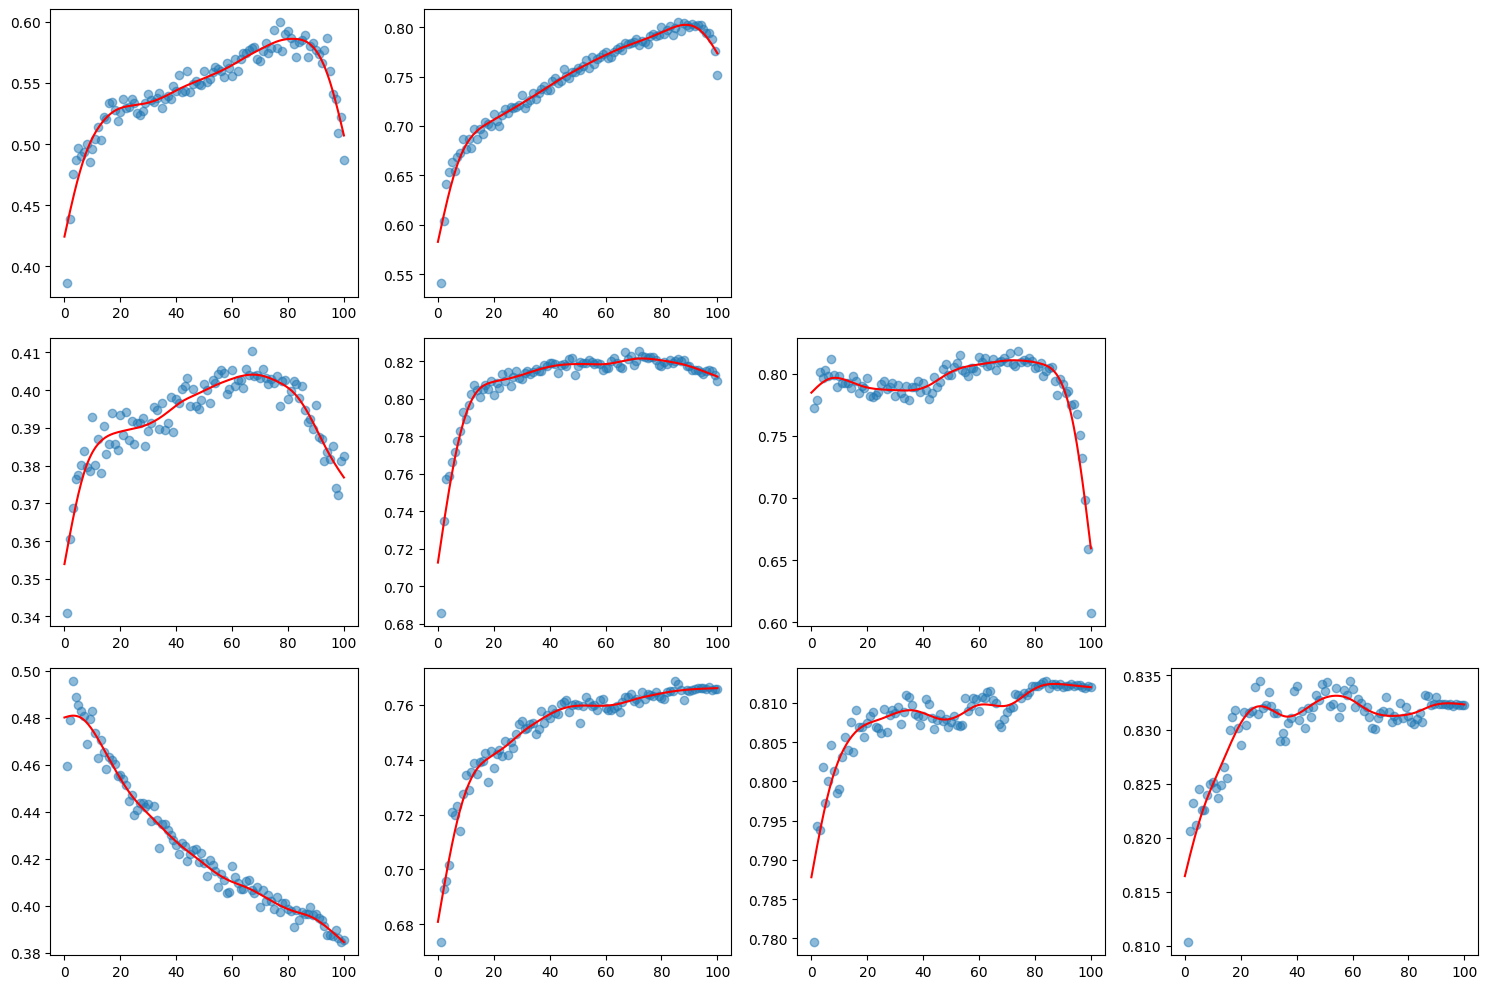

In [6]:
from pygam import LinearGAM, s

def plot_gam(df, compare_metric, ax):
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()



    # Assuming df is your dataframe
    X = grouped["rank"].values
    y = grouped[compare_metric].values


    gam = LinearGAM(s(0))

    # Fit the model to the data
    gam.fit(X, y)

    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)

    # Plot the results
    import matplotlib.pyplot as plt


    ax.scatter(X, y, label='Data', alpha=0.5)
    ax.plot(X_pred, y_pred, label='GAM Prediction', color='red')
    return ax


from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    
    yerr=[]
    if error_bar:
        for i in grouped.index:
            # print(grouped.loc[i][ylabel])
            _, c, s = grouped.loc[i][ylabel]
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), color="red")
    return ax



def qualitative_plots(models_array, figsize=(15,10)):
    
    nrows=len(models_array)
    ncols=max(len(s) for s in models_array)
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, suite_models in enumerate(models_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(suite_models):
                model_name=suite_models[col]
                print(f"model_name is {model_name}")

                filtered_df=dfs_by_model[model_name]
                def calculate_title():
                    readable_model=get_model_details(model_name)['name']
                    return f"{readable_model}: {suptitle}" if ax is None else readable_model
                # plot by rank within sentence
                suptitle="Grouped by rank within sentence"

                # ax=plot_smooth_spline(filtered_df, xlabel="rank", ylabel=compare_metric, groupby='example_idx', figsize=(10,10), ax=ax)
                ax=plot_gam(df=filtered_df, compare_metric=compare_metric, ax=ax)
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()

qualitative_plots(size_array)


model_name is meta_llama_Llama_3.2_1B_Instruct
model_name is meta_llama_Llama_3.1_8B_Instruct
model_name is allenai_OLMo_2_0425_1B_Instruct
model_name is allenai_OLMo_2_1124_7B_Instruct
model_name is allenai_OLMo_2_1124_13B_Instruct
model_name is Qwen/Qwen3-0.6B
model_name is Qwen/Qwen3-1.7B
model_name is Qwen/Qwen3-4B
model_name is Qwen/Qwen3-8B


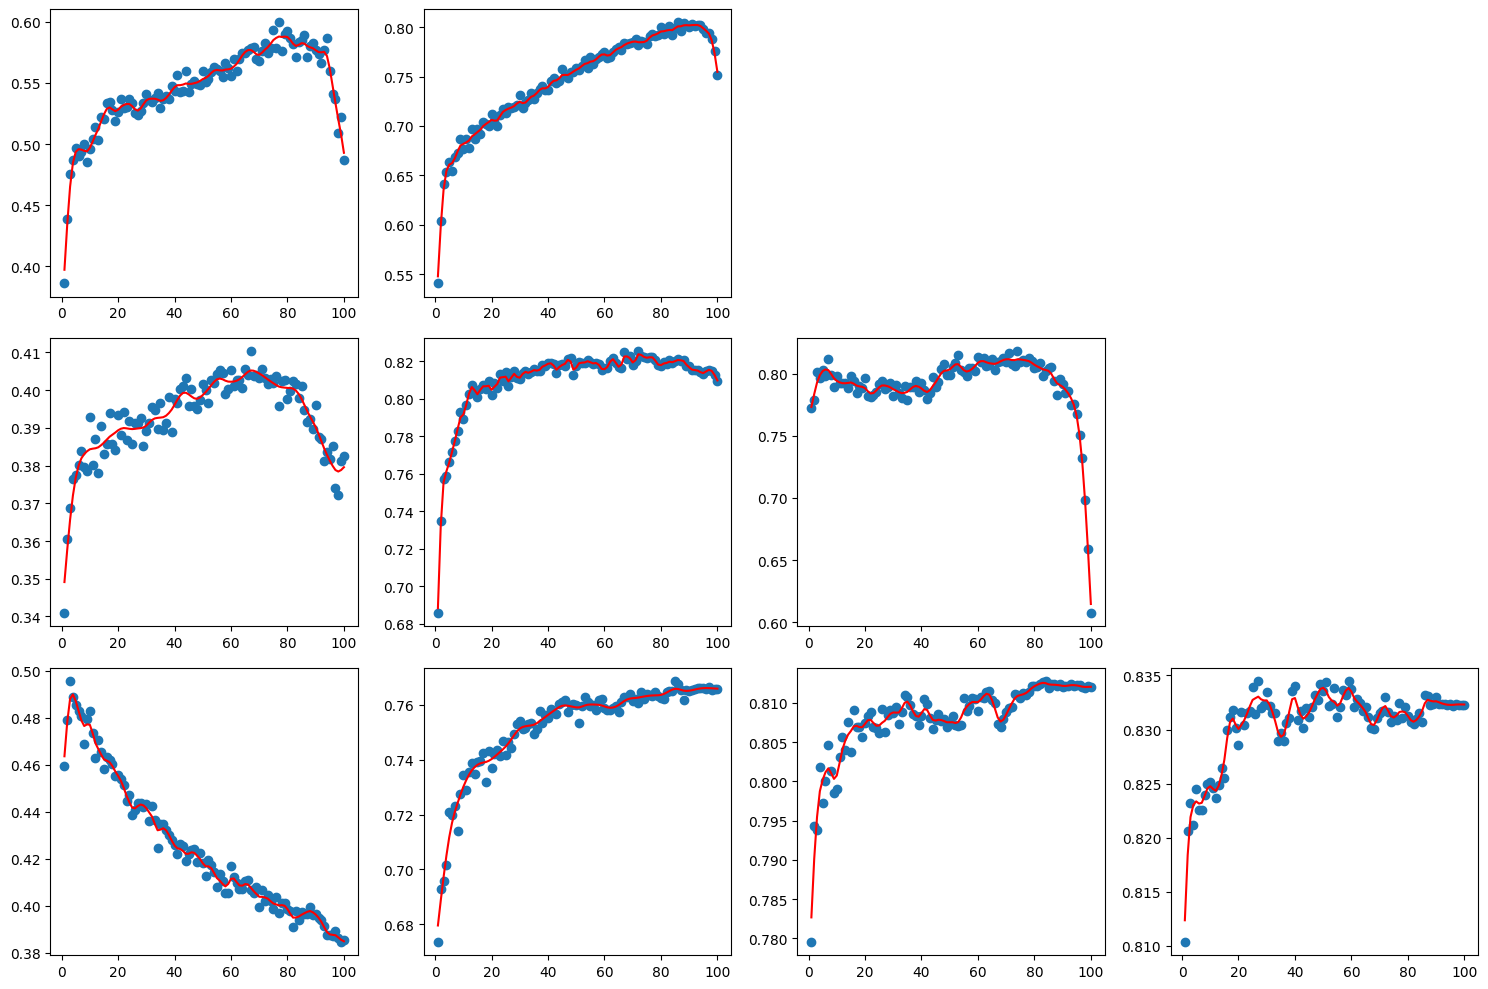

In [7]:
from pygam import LinearGAM, s

def plot_gam(df, compare_metric, ax):
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()



    # Assuming df is your dataframe
    X = grouped["rank"].values
    y = grouped[compare_metric].values


    gam = LinearGAM(s(0))

    # Fit the model to the data
    gam.fit(X, y)

    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)

    # Plot the results
    import matplotlib.pyplot as plt


    ax.scatter(X, y, label='Data', alpha=0.5)
    ax.plot(X_pred, y_pred, label='GAM Prediction', color='red')
    return ax


from scipy.interpolate import make_smoothing_spline
def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    
    yerr=[]
    if error_bar:
        for i in grouped.index:
            # print(grouped.loc[i][ylabel])
            _, c, s = grouped.loc[i][ylabel]
            yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    spl = make_smoothing_spline(x, y)
    ax.plot(x, spl(x), color="red")
    return ax



def qualitative_plots(models_array, figsize=(15,10)):
    
    nrows=len(models_array)
    ncols=max(len(s) for s in models_array)
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, suite_models in enumerate(models_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(suite_models):
                model_name=suite_models[col]
                print(f"model_name is {model_name}")

                filtered_df=dfs_by_model[model_name]
                def calculate_title():
                    readable_model=get_model_details(model_name)['name']
                    return f"{readable_model}: {suptitle}" if ax is None else readable_model
                # plot by rank within sentence
                suptitle="Grouped by rank within sentence"

                ax=plot_smooth_spline(filtered_df, xlabel="rank", ylabel=compare_metric, groupby='example_idx', figsize=(10,10), ax=ax)
                ax.set_xlabel(None)
                ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()

qualitative_plots(size_array)
